# Average-Reward MDP Relative Value Iteration Implementation

## Setup

### Libraries & Helper Class

In [1]:
from collections import defaultdict # this is a useful data structure for storing the transition probabilities and rewards for each state

import numpy as np
np.random.seed(42)

import math

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# show gridworld_visual picture which in the path /content/drive/MyDrive/Average Reward MDP Policy Optimization/gridworld_visual.png
# from IPython.display import Image
# Image(filename='/content/drive/MyDrive/Average Reward MDP Policy Optimization/gridworld_visual.png', width=300)

In [2]:
from typing import Tuple

class GridHelper:
    def __init__(self, n: int):
        self.n: int = n

    def coord_to_index(self, x: int, y: int) -> int:
        return x * self.n + y

    def index_to_coord(self, index: int) -> Tuple[int, int]:
        return divmod(index, self.n)

    def manhattan_distance(self, a: int, b: int) -> int:
        ax, ay = self.index_to_coord(a)
        bx, by = self.index_to_coord(b)
        return abs(ax - bx) + abs(ay - by)

### States and Helpers

In [3]:
n = 4 # Size of the grid

first_ambulance_index = 0
last_ambulance_index = n**2 - 1

states = [(a1, a2) for a1 in range(0, n**2 - 1) for a2 in range(0, n**2 - 1) if a1 != a2]
states.append((0, 0))

In [4]:
print("Total number of states:", len(states))

Total number of states: 211


In [25]:
# we need to map states to indices for easier access
state2idx = {s: k for k, s in enumerate(states)}

In [ ]:
state2idx

In [5]:
grid_helper = GridHelper(n)

### Parameters

#### Service Time and Arrival Rate

In [6]:
# define an np array to hold the expected service time for each patient location and ambulance spot
expected_service_time = np.zeros((n**2-2, 2))  # in hours
for j in range(0, 2):
    for i in range(1, n**2 - 1):
        if j == 0:
            man_distance = grid_helper.manhattan_distance(i, 0)
        else:
            man_distance = grid_helper.manhattan_distance(i, n**2 - 1)
        expected_service_time[i-1, j] = np.random.normal(man_distance*3,1,1)/60 #here we are just generating numbers by using normal dist.

In [ ]:
expected_service_time # in hours

In [ ]:
expected_service_time*60 # in minutes

In [7]:
coverage_reward_prob_high = np.vectorize(lambda x: 1 - math.exp(-(1/x) * 1/6))(expected_service_time) # probability of the service less than 10 minutes
coverage_reward_prob_high

array([[0.94272137, 0.52918545],
       [0.81840554, 0.58284637],
       [0.64531234, 0.71406995],
       [0.89039884, 0.4795111 ],
       [0.82348522, 0.5940611 ],
       [0.68043321, 0.7323093 ],
       [0.52117482, 0.73801508],
       [0.77183011, 0.57229129],
       [0.69033392, 0.66807173],
       [0.54944963, 0.88759783],
       [0.49737937, 0.98296177],
       [0.69017459, 0.66632362],
       [0.55818432, 0.87283606],
       [0.53426265, 0.94830273]])

In [8]:
coverage_reward_prob_low = coverage_reward_prob_high/10 #reward for the low priority requests are 9 times less than the high priority requests
coverage_reward_prob_low

array([[0.09427214, 0.05291855],
       [0.08184055, 0.05828464],
       [0.06453123, 0.071407  ],
       [0.08903988, 0.04795111],
       [0.08234852, 0.05940611],
       [0.06804332, 0.07323093],
       [0.05211748, 0.07380151],
       [0.07718301, 0.05722913],
       [0.06903339, 0.06680717],
       [0.05494496, 0.08875978],
       [0.04973794, 0.09829618],
       [0.06901746, 0.06663236],
       [0.05581843, 0.08728361],
       [0.05342626, 0.09483027]])

In [9]:
arr_rate = 2.0          # arrivals per hour

#### Probability of a Request from the Cells

In [10]:
P = np.zeros(n**2) # arrival-location pmf
for i in range(n**2):
    # The first and last indices are the hospitals, so we set their probabilities to 0.
    # This means that the ambulance will never be dispatched to these locations.
    if i == 0 or i == n**2 - 1:
        P[i] = 0.0
    else:
        P[i] = np.random.uniform(0, 1)
P /= np.sum(P)

In [ ]:
P

In [11]:
print(np.sum(P))  # should be 1.0

1.0


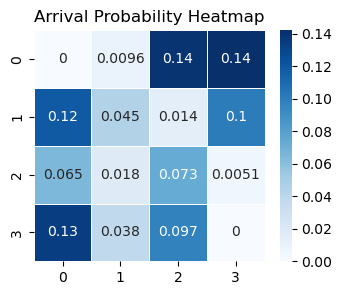

In [12]:
# heatmap representation of the arrival probabilities
plt.figure(figsize=(4, 3))
sns.heatmap(P.reshape(n, n), annot=True, cmap='Blues', square=True, linewidths=0.5)  
plt.title('Arrival Probability Heatmap')
plt.xticks(ticks=np.arange(n) + 0.5, labels=np.arange(n))
plt.yticks(ticks=np.arange(n) + 0.5, labels=np.arange(n))
plt.grid(False)
plt.show()

#### Conditional Probability Values for High and Low Priority Patients

In [13]:
P_low = np.zeros(n**2) # arrival-location pmf
P_low[0] = 0.0  # hospital/ambulance 1
P_low[1] = 0.3
P_low[2] = 0.35
P_low[3] = 0.35
P_low[4] = 0.37
P_low[5] = 0.33
P_low[6] = 0.39
P_low[7] = 0.42
P_low[8] = 0.44
P_low[9] = 0.45
P_low[10] = 0.49
P_low[11] = 0.56
P_low[12] = 0.57
P_low[13] = 0.65
P_low[14] = 0.61
P_low[15] = 0.0 # hospital/ambulance 2

In [14]:
P_high = np.zeros(n**2)
P_high = 1 - P_low
P_high[0]= 0.0  # hospital/ambulance 1
P_high[n**2-1] = 0.0 # hospital/ambulance 2
P_high

array([0.  , 0.7 , 0.65, 0.65, 0.63, 0.67, 0.61, 0.58, 0.56, 0.55, 0.51,
       0.44, 0.43, 0.35, 0.39, 0.  ])

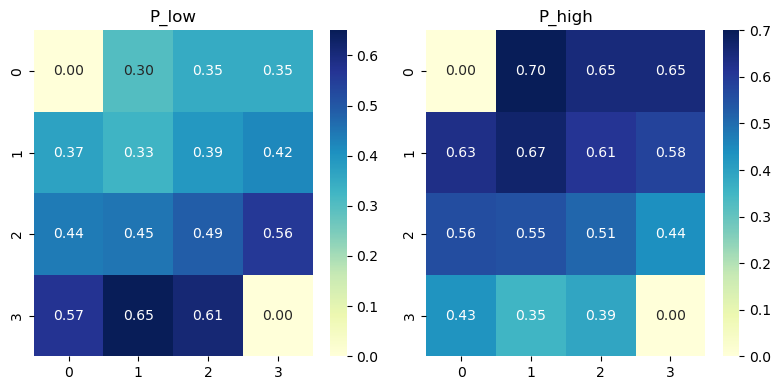

In [15]:
# show P_low and P_high heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(P_low.reshape(n, n),  annot=True, fmt=".2f", ax=axes[0], cmap="YlGnBu")
axes[0].set_title("P_low")  
sns.heatmap(P_high.reshape(n, n), annot=True, fmt=".2f", ax=axes[1], cmap="YlGnBu")
axes[1].set_title("P_high")
plt.tight_layout()
plt.show()

In [16]:
# combine P_low and P_high into two-dimensional array
P_pri_combined = np.zeros((2, n**2))
P_pri_combined[0, :] = P_low
P_pri_combined[1, :] = P_high

### Actions

In [17]:
def actions(s):
    idle_providers = []
    if s[0] == 0:  idle_providers.append(0)   # provider at cell 0
    if s[1] == 0:  idle_providers.append(1)   # here 1 indicated the second ambulance which is at cell n**2 - 1
    return idle_providers if idle_providers else [None]   # None = null dispatch

### Event Rates

In [18]:
mu_max_0 = np.max(expected_service_time[:,0])
mu_max_1 = np.max(expected_service_time[:,1])

print("Maximum service time for ambulance 0:", mu_max_0)
print("Maximum service time for ambulance 1:", mu_max_1)

Maximum service time for ambulance 0: 0.24227637178645894
Maximum service time for ambulance 1: 0.25523745554325455


In [19]:
# this is needed for the normalization procedure. Here normalization is a process of transforming a continuous 
# Markov Decision Process (MDP) into a discrete one by scaling transition probabilities.
gamma = arr_rate + (1/(mu_max_0 + mu_max_1))
gamma

4.009994386220903

## Transitions

In [20]:
def transitions(s, a):
    
    # input:  (state s, action a)
    # output: (next_state, prob, reward) !not one, all possible transitions from state s with action a
    
    out = defaultdict(float)

    # --- 1. Service completions ------------------------------------------
    for p_idx, provider_cell in enumerate((0, 1)): # to understand these, you need to remember the state representation which is a
        # tuple of two indices representing the ambulances' positions or 0 if the ambulance is idle. Also we have two ambulances which are
        # represented by indices 0 and 1.
        job = s[p_idx]
        if job != 0:
            rate   = expected_service_time[job-1, provider_cell]
            prob   = rate / gamma
            s_next = list(s)                # copy current state
            s_next[p_idx] = 0               # provider becomes idle
            out[tuple(s_next), 0.0] += prob # add self-loop with zero reward

    # --- 2. Customer arrival ---------------------------------------------
    prob_arr = arr_rate / gamma
    for i in range(16):
        for j in range(2): # this is for two priorities (low(0) and high(1))
            if P[i] == 0:               # skip provider cells
                continue
            if a is None:               # both providers busy ⇒ null dispatch
                # here, you may want to count total number of request that are not served
                s_next = s             # state unchanged
                out[s_next, 0.0] += prob_arr * P[i] * P_pri_combined[j, i]
            else:         # dispatch chosen idle provider
                p_idx = 0 if a == 0 else 1 # you can also use 'a' directly as an index since it is either 0 or 1
                s_next = list(s)
                s_next[p_idx] = i
                if s_next[0] == s_next[1]:  # the states where both ambulances are at the same location are not allowed such as (1,1) or (5,5).(0,0) is allowed tho.
                    s_next_no = s
                    out[s_next_no, 0.0] += prob_arr * P[i] * P_pri_combined[j,i]  # no change in state, just probability
                else:
                    if j == 0:
                        reward = coverage_reward_prob_low[i-1, a]
                        out[tuple(s_next), reward] += prob_arr * P[i] * P_pri_combined[j, i]
                    else:
                        reward = coverage_reward_prob_high[i-1, a]
                        out[tuple(s_next), reward] += prob_arr * P[i] * P_pri_combined[j, i]
                    
                
    # --- 3. Dummy self-loop ----------------------------------------------
    residual = 1.0 - sum(prob for (_, prob) in out.items())
    out[s, 0.0] += residual

    # convert to list of tuples
    return [(ns, prob, r) for (ns, r), prob in out.items()]

In [26]:
gh = transitions((0, 0), 1)  # test transitions function with state (0, 0) and action 0
gh

[((0, 1), 0.0014320455292216243, 0.05291854531629878),
 ((0, 1), 0.00334143956818379, 0.5291854531629878),
 ((0, 2), 0.024370223190176944, 0.05828463660460932),
 ((0, 2), 0.04525898592461433, 0.5828463660460932),
 ((0, 3), 0.024800323370645486, 0.07140699513726138),
 ((0, 3), 0.04605774340262733, 0.7140699513726139),
 ((0, 4), 0.021948469380434793, 0.04795110970764414),
 ((0, 4), 0.037371718134253835, 0.47951109707644146),
 ((0, 5), 0.00737634303622763, 0.0594061100275356),
 ((0, 5), 0.01497621161900761, 0.594061100275356),
 ((0, 6), 0.0027951996270307103, 0.07323093001440427),
 ((0, 6), 0.004371978903817264, 0.7323093001440427),
 ((0, 7), 0.021087784668054846, 0.07380150757993838),
 ((0, 7), 0.02912122644636146, 0.7380150757993837),
 ((0, 8), 0.014211289226506668, 0.057229128759378856),
 ((0, 8), 0.018087095379190305, 0.5722912875937886),
 ((0, 9), 0.004029823880941198, 0.0668071728171474),
 ((0, 9), 0.004925340298928131, 0.668071728171474),
 ((0, 10), 0.017804677046876372, 0.08875978

In [22]:
gh = transitions((0, 7), 0)  # test transitions function with state (0, 0) and action 0
gh

[((0, 0), 0.031029340068300888, 0.0),
 ((1, 7), 0.0014320455292216243, 0.09427213715791702),
 ((1, 7), 0.00334143956818379, 0.9427213715791701),
 ((2, 7), 0.024370223190176944, 0.0818405543691149),
 ((2, 7), 0.04525898592461433, 0.818405543691149),
 ((3, 7), 0.024800323370645486, 0.06453123396764181),
 ((3, 7), 0.04605774340262733, 0.6453123396764181),
 ((4, 7), 0.021948469380434793, 0.08903988443436403),
 ((4, 7), 0.037371718134253835, 0.8903988443436403),
 ((5, 7), 0.00737634303622763, 0.08234852218718104),
 ((5, 7), 0.01497621161900761, 0.8234852218718104),
 ((6, 7), 0.0027951996270307103, 0.06804332109488306),
 ((6, 7), 0.004371978903817264, 0.6804332109488306),
 ((0, 7), 0.5204258556112668, 0.0),
 ((8, 7), 0.014211289226506668, 0.07718301080456429),
 ((8, 7), 0.018087095379190305, 0.7718301080456429),
 ((9, 7), 0.004029823880941198, 0.06903339153939121),
 ((9, 7), 0.004925340298928131, 0.6903339153939121),
 ((10, 7), 0.017804677046876372, 0.054944963036381925),
 ((10, 7), 0.018531

## Relative Value Iteration

In [23]:
def rvi(eps=1e-8, max_iter=10000):
    V = np.zeros(len(states))
    # best action value for each state
    
    g = 0.0                             # bias estimate
    ref = 0                             # choose arbitrary reference state
 
    for it in range(max_iter):
        V_new = np.empty_like(V) # this will create a new array with the same shape and dtype as V but its contents are uninitialized
        g_num = 0.0

        for k, s in enumerate(states):
            best = -np.inf
            for a in actions(s):
                q = 0.0
                for ns, p, r in transitions(s, a): # this was already defined above. It's quite critical to understand how the transitions work
                    q += p * (r + V[state2idx[ns]])
                best = max(best, q)
            V_new[k] = best
            g_num  += best

        g_new = g_num / len(states)     # average over states
        V_new -= V_new[ref]             # anchor
        
        if it % 100 == 0:
            print(f"Iteration {it}, g = {g:.4f}, max |V_new - V| = {np.max(np.abs(V_new - V)):.10f}")
            
        if np.max(np.abs(V_new - V)) < eps:
            return g_new, V_new

        V, g = V_new, g_new

    raise RuntimeError("RVI failed to converge")


In [27]:
final_average_reward, V = rvi()

Iteration 0, g = 0.0000, max |V_new - V| = 0.2070269055
Iteration 100, g = -0.5064, max |V_new - V| = 0.0041846036
Iteration 200, g = -0.5259, max |V_new - V| = 0.0011050723
Iteration 300, g = -0.5305, max |V_new - V| = 0.0003325297
Iteration 400, g = -0.5319, max |V_new - V| = 0.0001067458
Iteration 500, g = -0.5323, max |V_new - V| = 0.0000355919
Iteration 600, g = -0.5324, max |V_new - V| = 0.0000121499
Iteration 700, g = -0.5325, max |V_new - V| = 0.0000042099
Iteration 800, g = -0.5325, max |V_new - V| = 0.0000014726
Iteration 900, g = -0.5325, max |V_new - V| = 0.0000005182
Iteration 1000, g = -0.5325, max |V_new - V| = 0.0000001831
Iteration 1100, g = -0.5325, max |V_new - V| = 0.0000000648
Iteration 1200, g = -0.5325, max |V_new - V| = 0.0000000230


In [28]:
V

array([ 0.        , -0.0393533 , -0.17171271,  0.04248827, -0.0461798 ,
       -0.15894658, -0.18190031, -0.02995105, -0.09934779, -0.40664218,
       -0.90943617, -0.09142073, -0.35844752, -0.61215672, -0.6466744 ,
       -0.8936386 , -1.00814549, -0.8275313 , -0.90112761, -1.01714537,
       -1.02859159, -0.88604357, -0.95692409, -1.26270437, -1.77744098,
       -0.95365768, -1.22230475, -1.47479682, -0.34929753, -0.54600773,
       -0.69379711, -0.5153041 , -0.58730447, -0.69846544, -0.71175866,
       -0.57270315, -0.6404544 , -0.93835987, -1.44282805, -0.63650714,
       -0.89692829, -1.14526624, -0.13230561, -0.33016361, -0.36541107,
       -0.29757885, -0.37247256, -0.48442544, -0.49987689, -0.35751483,
       -0.42585979, -0.72702165, -1.23195627, -0.42110377, -0.68371707,
       -0.93404417, -0.49355119, -0.69467085, -0.72897548, -0.84176404,
       -0.73616544, -0.84848205, -0.8607552 , -0.72150492, -0.78999989,
       -1.08913673, -1.59590738, -0.78642657, -1.04848066, -1.29